In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras as keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [45]:
fermo = pd.read_csv("fermo.csv")

fermo.loc[fermo.index < 200, 'activity'] = 'still'
fermo.loc[(fermo.index >= 200) & (fermo.index < 400), 'activity'] = 'walking'
fermo.loc[(fermo.index >= 400), 'activity'] = 'running'

#mov = pd.read_csv("mov.csv")'
#mov['activity'] = 'walking'


print("Dimensione dataset fermo: ", fermo.shape)

Dimensione dataset fermo:  (600, 12)


In [59]:
enc = OneHotEncoder(sparse_output=False)
new_df = pd.DataFrame(enc.fit_transform(fermo['activity'].to_numpy().reshape(-1, 1)), columns=['running', 'still', 'walking'])
new_df.index = fermo.index

encoded_df = pd.concat([fermo, new_df], axis=1)
encoded_df.drop('activity', axis=1, inplace=True)
encoded_df




,xa,ya,za,xg,yg,zg,xm,ym,zm,temp,hum,running,still,walking
0,0.011,-0.051,0.989,0.122,2.258,-1.770,-10.022,29.797,-31.812,19.720,43.931,0.0,1.0,0.0
1,0.011,-0.050,0.992,-0.061,2.136,-1.892,-9.363,29.541,-30.554,19.756,43.998,0.0,1.0,0.0
2,0.011,-0.050,0.993,-0.183,2.258,-1.953,-9.839,29.260,-30.225,19.756,44.036,0.0,1.0,0.0
3,0.010,-0.050,0.993,-0.122,2.380,-1.770,-9.619,29.468,-28.833,19.774,43.985,0.0,1.0,0.0
4,0.010,-0.050,0.994,-0.122,2.319,-1.831,-9.827,29.382,-29.382,19.774,44.062,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.010,-0.050,0.994,0.061,2.380,-1.770,-10.449,29.834,-29.919,19.936,43.462,1.0,0.0,0.0
596,0.010,-0.049,0.993,-0.061,2.258,-1.892,-9.875,30.322,-30.273,19.936,43.513,1.0,0.0,0.0
597,0.009,-0.050,0.994,-0.183,2.197,-2.014,-9.460,30.615,-29.761,19.954,43.513,1.0,0.0,0.0
598,0.010,-0.049,0.994,-0.061,2.258,-1.953,-9.937,29.822,-30.042,19.936,43.484,1.0,0.0,0.0


Test di standardizzazione

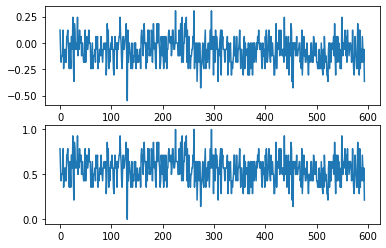

In [85]:
standardizer = MinMaxScaler()
no_outliers = pd.DataFrame(fermo.loc[abs(fermo.xg) < 1, 'xg'])
no_outliers
y = standardizer.fit_transform(no_outliers)
y

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(np.arange(0, len(y)), no_outliers)
ax2.plot(np.arange(0, len(y)), y)

# Modello

In [ ]:
model = keras.Sequential([
    layers.Dense(units = 256, input_shape=[11], activation='relu'),
    layers.Dropout(rate=0.3),
    layers.BatchNormalization(),
    layers.Dense(units = 256, activation = 'relu'),
    layers.Dropout(rate=0.3),
    layers.BatchNormalization(),
    layers.Dense(units = 256, activation = 'relu'),
    layers.Dropout(rate=0.3),
    layers.BatchNormalization(),
    layers.Dense(units = 3, activation = 'softmax')
])

Modello - ottimizzatore e funzione di perdita

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

Early stopping per evitare overfitting

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=100,
    callbacks=[early_stopping],
)